# Wiener Deconvolution

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2018  
> Email: [samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

---

## Contents

1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Example](#Example)
1. [Unsupervised Deconvolution](#Unsupervised-Deconvolution)

---

## Set-Up

Here we will import a couple of packages that will be needed throughout the notebook. 

Users new to Jupyter notebooks should note that cells are executed by pressing <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (&#x21E7;+ &#x23ce;). See <a href="https://jupyter-notebook.readthedocs.io/en/stable/" target_="blanck">here</a> for more details.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt

# Import convolution routines from Astropy
from astropy.convolution import convolve_fft

# Import Richardson-Lucy method from SciKit-Image
from skimage.restoration import wiener, unsupervised_wiener

# Import NMSE metric from sf_tools
from sf_tools.image.quality import nmse

---

## Introduction

This notebook demonstrates the [Wiener](https://en.wikipedia.org/wiki/Wiener_deconvolution)
method for deconvolution.

The method is named after Norbert Wiener []() and takes the form

$$\hat{x} = g * y$$

where $y$ is the obeserved image, $\hat{x}$ is the deconvolved image, and $g$ is given by

$$g = \mathcal{F}^{-1}\left(\frac{1}{\mathcal{F}(H)}\left[\frac{|\mathcal{F}(H)|^2}{|\mathcal{F}(H)|^2 + \frac{1}{\textrm{SNR}}}\right]\right)$$

where $H$ is the PSF, and SNR is the signal-to-noise ratio.

We can implement this by first defining a convolution method,

In [2]:
# Convolution Method
def convolve(image, kernel):
            
    return convolve_fft(image, kernel, boundary='wrap', crop=False,
                        nan_treatment='fill', normalize_kernel=False)

then the deconvolution method.

In [3]:
def Wiener_Deconvolve(image, psf, snr=0):
    
    trans_func = np.fft.fft2(psf)
    
    wiener_filter = np.conj(trans_func) / (np.abs(trans_func) ** 2 + (1.0 / snr))
        
    return np.real(np.fft.fftshift(np.fft.ifft2(wiener_filter * np.fft.fft2(image))))

---

## Example

Below we demonstrate the deconvolution method on astrophysical data. First we define a data set.

In [4]:
# Load an example galaxy image
x = np.load('/Users/farrens/Documents/Projects/PSF/data/clean_data/deep_galaxy_cube_10000_norm.npy')[8]

# Load an example PSF
H = np.load('/Users/farrens/Documents/Projects/PSF/data/psf/euclid_psf_wl0.6_norm.npy')[0]

# Set a noise levl
sigma = 0.00005

# Convolve the galaxy image with the PSF and add Gaussian random noise
y = convolve(x, H) + np.random.randn(*x.shape) * sigma

# Print the SNR of the image
snr = np.std(convolve(x, H)) / sigma
print('SNR = {}'.format(snr))

SNR = 47.561130306334434


Then we apply the Wiener algorithm defined above along with that provided by [SciKit-Image](http://scikit-image.org/docs/dev/api/skimage.restoration.html?highlight=richardson#skimage.restoration.wiener) for comparison.

In [5]:
# Apply Wiener deconvolution
x_w = Wiener_Deconvolve(y, H, snr=snr)

# Apply SciKit-Image implementation or Wiener deconvolution
x_skw = wiener(y, H, balance=(1.0 / snr))

The results are displayed in the following figures.

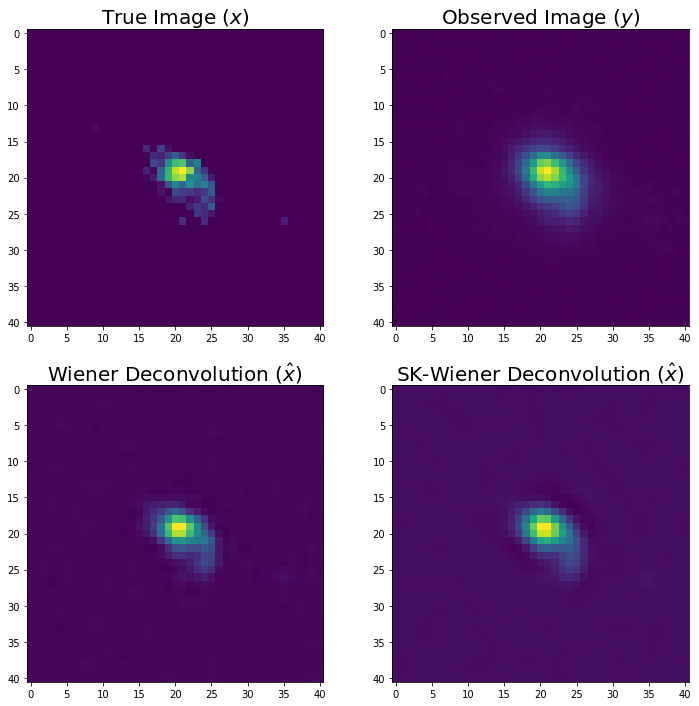

In [6]:
# Set the figure properties
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Plot the true image
ax[0, 0].imshow(x)
ax[0, 0].set_title('True Image ($x$)', fontsize=20)

# Plot the observed image
ax[0, 1].imshow(y)
ax[0, 1].set_title('Observed Image ($y$)', fontsize=20)

# Plot the Richardson-Lucy deconvolution
ax[1, 0].imshow(x_w)
ax[1, 0].set_title('Wiener Deconvolution ($\hat{x}$)', fontsize=20)

# Plot the SciKit-Image deconvolution
ax[1, 1].imshow(x_skw)
ax[1, 1].set_title('SK-Wiener Deconvolution ($\hat{x}$)', fontsize=20)

# Display the plots
plt.show()

The quality of the deconvolutions is measured using the Normalised Mean Square Error (NMSE).

In [7]:
# Print the NMSE between the true and Wiener deconvolved images
print('NMSE(x, x_w) = {}'.format(nmse(x, x_w)))

# Print the NMSE between the true and SK-Wiener deconvolved images
print('NMSE(x, x_skw) = {}'.format(nmse(x, x_skw)))

# Print the NMSE between the Wiener and SK-Wiener deconvolved images
print('NMSE(x_rl, x_skw) = {}'.format(nmse(x_w, x_skw)))

NMSE(x, x_w) = 0.05062301102243147
NMSE(x, x_skw) = 0.06775478162334876
NMSE(x_rl, x_skw) = 0.009718077541320983


---

## Unsupervised Deconvolution

Scikit-Image additionally offers an [unsupervised version](http://scikit-image.org/docs/dev/api/skimage.restoration.html?highlight=richardson#unsupervised-wiener) of the Wiener method, where the SNR is automatically estimated from the input data.

This can be implemented as follows.

In [8]:
x_skuw = unsupervised_wiener(y, H)[0]

The results are shown below.

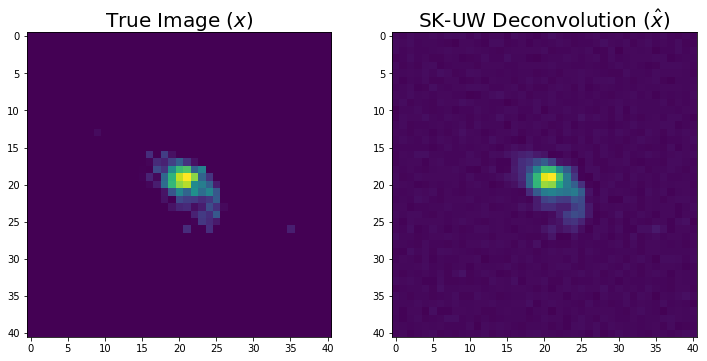

In [11]:
# Set the figure properties
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Plot the true image
ax[0].imshow(x)
ax[0].set_title('True Image ($x$)', fontsize=20)

# Plot the SciKit-Image deconvolution
ax[1].imshow(x_skuw)
ax[1].set_title('SK-UW Deconvolution ($\hat{x}$)', fontsize=20)

# Display the plots
plt.show()

In [10]:
# Print the NMSE between the true and SK-Wiener deconvolved images
print('NMSE(x, x_skw) = {}'.format(nmse(x, x_skuw)))

NMSE(x, x_skw) = 0.03675603422166656
